In [20]:
from IPython.core.display import display, HTML
import pandas as pd

### Introduction 

This outlines the procedure taken to build a genetic algorithm to accurately play Missile Command, below is the end result of 250 epochs:

In [21]:
display(HTML('<img src="model_result_sample.gif" width="750" align="center">'))

The solution as explained before was a genetic algorithm that trained through mutation to understand how to play the most efficiently and survive the longest.

For this project, an open source minimal version of the game is used:  
https://github.com/Forestf90/MissileCommand

The important rules for this game are:

- Each round 10 (arbitrary amount) rockets shoot downwards
- There are 6 shelters (blue squares) that the player must protect
- Once all 6 are destroyed, the game is over

The scoring Selection used for each of the models is the inverse distance from the player rocket to the closes enemy rocket, this encourages the model to shoot closer to each of the missiles. As well there is a point boost if an enemy rocket is destroyed.

### Model Creation 

**Structure**  
The model is a 1 layer neural network represented through numpy arrays as weights. The model has 3 primary functionalities:

**1. feed_forward**  
This function takes in an array of inputs, then computes the desired output for the model by multiplying the input with the weights, summing up all values per output and trimming excess values.

**2. Mutate**  
This function is used on each new generation of models after one training step, it randomly (10%) mutates a genome (weight) in the model by altering its value.

**3. Save**  
This function simply saves the weights as a .npy file to be accessible elsewhere

**Data**  
As mentioned before, the model has input and output data:

**Input**    
The models input data is an array of length 5, which consists of:
- Bias 
- Closest Rocket X value
- Closest Rocket Y Value
- Closest Rocket Proceeding X value
- Closest Rocket Proceeding Y value

**Output**  
The output for this model is an array of length 3, which consists of:
- Fire (if > 0.5 it makes the decision to fire)
- X (x value of where the rocket should go)
- Y (y value of where the rocket should go)

### Model Building 

In [22]:
def randomize(x):
    r = np.random.random()
    if r <= 0.1:
        return np.random.uniform(-1, 1)
    elif r <= 0.2:
        return x + np.random.uniform(-0.1, 0.1)
    return x

In [23]:
def trim(x):
    if x >= 1:
        return 1
    elif x<= -1:
        return -1
    return x

In [24]:
class Model():
    def __init__(self, weights=None):
        """When class is created, it is either created with previos weights, or randomly initiated

        -Input size is 49 (of data points)
        -Output size is 3 (shoot, x and y)
        -Model has a 10% chance to mutate each weight
        """
        self.input_size = 5
        self.output_size = 3

        if weights is None:
            self.weights = np.array([[0.4,0,1,0,0],[0,0,0,1,0], [0,0,0,0,1]])
        else:
            self.weights = weights

    def feed_forward(self, inputs):
        return [trim(i) for i in (inputs * self.weights).sum(axis=1)]

    def mutate(self):
        """When mutating, there is a 10% chance per weight to reinitialize (randomize) its value.
        """

        self.weights = np.array([[randomize(i) for i in array] for array in self.weights])

    def save(self, file_name):
        np.save(file_name, self.weights)

### Controller

The controller is where the management of the training goes, it follows these steps:

**1. Build models**  
Prepares X amount of models to train by randomizing initial weights

**2. Training**  
For each Epoch it runs each of the models on a fresh game, and records all of their scores in a file, the file is used because the controller runs these games in parallel subprocesses for faster training times.

**3. Model Selection and mutation**  
Then the models are selected again by normalizing each of their scores, then their score values is used as weights when randomly selecting the models, meaning models with higher score will have a higher likely hood to be selected. Then each of these models are mutated.

**4. Repeat**  
Repeat all above steps

In [25]:
class Controller():
    def __init__(self):
        self.number_of_models = 100 #Number of Models
        self.number_of_threads = 10 #Number of cpus
        self.iteration_number = 1
        self.epochs = 1000
        self.directory = "training/"
        self.models = []
        self.times = []
        if os.path.exists(self.directory):
            self.load_previous_models()
        else:
            os.makedirs(self.directory)

    def load_previous_models(self):
        self.iteration_number = np.max([int(i) for i in os.listdir(self.directory)])

        if os.path.exists(self.directory + str(self.iteration_number)):
            shutil.rmtree(self.directory + str(self.iteration_number) + "/")

        self.training_step_dir = self.directory + str(self.iteration_number-1) + "/"
        for model_index in range(self.number_of_models):
            model = Model(np.load(self.training_step_dir + str(model_index) + ".npy"))
            self.models.append(model)

    def initialize_training(self):
        self.training_step_dir = self.directory + str(self.iteration_number) + "/"
        os.mkdir(self.training_step_dir)
        if self.iteration_number == 1:
            for model_index in range(self.number_of_models):
                model = Model()
                model.mutate()
                model.save(self.training_step_dir + str(model_index) + ".npy")
                self.models.append(model)
        else:
            for model_index, model in enumerate(self.models):
                model.save(self.training_step_dir + str(model_index) + ".npy")

    def train_step(self):
        self.scores = []
        """This is one step for training, each of the models runs the game, then total time is used as score

        Score is then scaled by dividing my total score value.
        """

        processes = []

        f = open(self.training_step_dir + "scores.txt", "w+")
        print("Epoch " + str(self.iteration_number))
        completed = 0
        model_index = 0
        while model_index < self.number_of_models:
            if len(processes) < self.number_of_threads:
                p = subprocess.Popen(f"python main_game_display.py --save_dir {self.training_step_dir} --model_index {model_index}", stdout=f)
                processes.append(p)
                time.sleep(0.1)
                model_index+=1

            new_completed = 0
            for poll in processes:
                if poll.poll() is None:
                    pass
                else:
                    new_completed+=1
                    processes.remove(poll)

        running = True
        while running:
            new_completed = 0
            running = False
            for poll in processes:
                if poll.poll() is None:
                    running = True
                else:
                    new_completed+=1
                    processes.remove(poll)


        model_scores = {}

        time.sleep(2)

        with open(self.training_step_dir + "scores.txt", "r") as f:
            self.scores = []
            for i in f.read().split("\n"):
                if len(list(model_scores.keys())) >= self.number_of_models:
                    break
                index = int(i.split(" - ")[0])
                value = float(i.split(" - ")[1])
                model_scores[index] = value

        self.scores = list(model_scores.values())

        self.times.append(np.max(self.scores))
        print(np.array(self.scores).round(2))
        print(str(np.average(self.scores)))
        print("\n")

        self.scores = np.array(self.scores)
        print(np.max(self.scores))
        self.scores = self.scores / np.sum(self.scores)

    def prepare_next_step(self):
        """Function called when models are finished training

        Randomly selects next models based on probability of total time
        Models are then mutated.
        """


        try:
            best_index = np.where(self.scores == np.max(self.scores))[0][0]
        except:
            best_index = np.random.randint(0, len(self.models)-1)

        select_models = random.choices([i for i in range(len(self.models))], self.scores, k=self.number_of_models)
        self.models = []

        for model_index in select_models:
            # 10% change to put in new model
            if np.random.random() < 0.1:
                self.models.append(Model())
            else:
                self.models.append(Model(np.load(self.training_step_dir + str(model_index) + ".npy")))

        select_models = random.choices([i for i in range(len(self.models))], self.scores, k=self.number_of_models - 1)

        new_models = [Model(weights=self.models[best_index].weights)]
        for model_index in select_models:
            #10% change to put in new model
            if np.random.random() < 0.1:
                new_models.append(Model())
            else:
                new_models.append(Model(weights=self.models[model_index].weights))

        for model in self.models:
            model.mutate()

        self.iteration_number += 1

### Training Summary 

Trained with **250 epochs** using **10 models** per epoch

In [26]:
import matplotlib.pyplot as plt

In [27]:
with open("all_scores.txt") as f:
    scores = f.read().split("\n")

In [28]:
scores = [float(i.split(" - ")[1]) for i in scores[:-1]]

In [29]:
df = pd.DataFrame(scores)

In [30]:
rolling = df.rolling(10).mean()

Text(0.5, 1.0, 'Score per epoch')

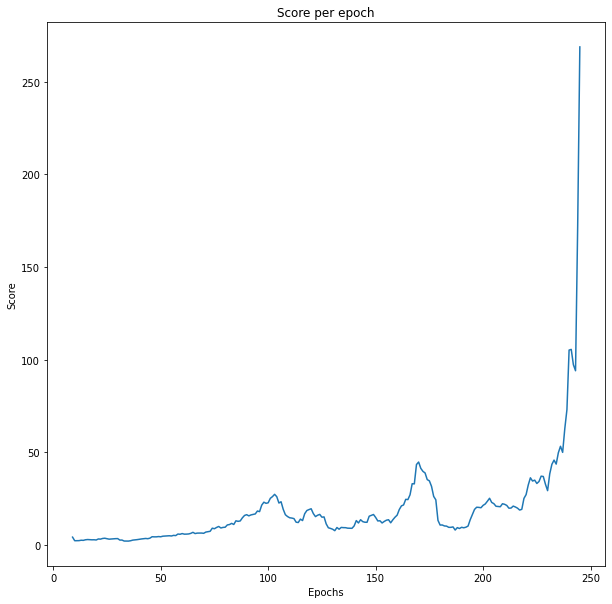

In [31]:
fig = plt.figure(figsize=(10,10))
plt.plot(rolling)
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Score per epoch")

### Testing

run this command in cmd:

In [ ]:
python main_game_display.py --save_dir "training_final/245/" --model_index 0 --testing True